# OMNY Analysis

This notebook is created with the goal of analysing transit data. By passing in a CSV dataset exported by NYC MTA's OMNY fare system, information such as time of day, trips per week, most-visited locations, and more can be determined

## Getting the CSV Data

- Go to https://omny.info/ and log in
- Go to Trips https://omny.info/account/trips and update the filter to show the past 12 months (the max time range possible)
- Scroll to the bottom of the page, click "Download trip history" and pick CSV and then download
- (Optional) manually merge this data with previously-downloaded data using Excel or Sublime
  - Alternatively, Pandas can read multiple CSV files and pick unique rows
- Place the CSV files in the same directory as the Jupyter notebook, aka this Git repo

In [1]:
# Load libraries
import pandas as pd # pd is the standard alias https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html
import seaborn as sns # sns is the convention https://seaborn.pydata.org/tutorial/introduction.html
import numpy as np
import calendar

## Loading the CSV Data

- Read the CSV files into Pandas as separate dataframes
- Merge them together using concat
- Get the unique rows based on Reference ID, in case the OMNY exports had overlapping data
- Resources
  - https://medium.com/@harryfry/combining-multiple-csv-files-into-one-with-pandas-97f631d67960
  - https://www.geeksforgeeks.org/how-to-merge-multiple-csv-files-into-a-single-pandas-dataframe/#
  - Use lower_case_with_underscore https://peps.python.org/pep-0008/#function-and-variable-names
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
  - https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [2]:
# Edit this to update the CSV data files to be considered
files_to_read = ['trip-history.csv','trip-history2.csv','trip-history3.csv']

# Read from CSV and concatenate in one line
# Index is not important and can be ignored 
df = pd.concat(map(pd.read_csv, files_to_read), ignore_index=True)

print('Raw CSV Data has row count of', len(df))

# Reference is a unique ID per fare payment, and can be used to get unique rows
df.drop_duplicates(subset=['Reference'],inplace=True,ignore_index=True)

print('Unique CSV Data has row count of', len(df))

Raw CSV Data has row count of 162
Unique CSV Data has row count of 152


## Massage and Format the DataFrame

- The DataFrame, upon initial read from CSV, is mostly Objects
```
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Reference          int64 
 1   Transit Account #  int64 
 2   Trip Time          object
 3   Mode               object
 4   Location           object
 5   Product Type       object
 6   Fare Amount ($)    object
dtypes: int64(2), object(5)
```
- However, many of the fields are categorical, meaning there is a finite set of possibile values. This allows Pandas to process it more efficiently
- Some fields are also date-based or numeric, and can be interpreted as such
- The column names can also be hard to reference, given their whitespace and special characters. They can be renamed
- Resources
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
  - https://lifewithdata.com/2022/02/28/how-to-convert-a-string-column-to-float-in-pandas/
  - https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas
  - https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
  - Date filtering https://sparkbyexamples.com/pandas/pandas-filter-dataframe-rows-on-dates/

In [3]:
# Rename columns to be easier to reference
df = df.rename(columns={'Reference':'trip_id',
                   'Transit Account #':'rider_id',
                   'Trip Time':'start_time',
                   'Mode':'transit_mode',
                   'Location':'start_location',
                   'Product Type':'product_type',
                   'Fare Amount ($)':'fare_cost'})

# Optional: Filter the DataFrame down between a specific start and end date
#df = df[(df['start_time'] > "2020-09-20") & (df['start_time'] < "2021-11-17")]

# Convert categorical fields from object to category
df = df.astype({'rider_id': 'category','transit_mode': 'category','start_location': 'category','product_type': 'category'})

# Convert object column with "$2.75" to a float, stripping out the $ to prepare it for interpretation
df['fare_cost'] = df['fare_cost'].astype(str).str.replace('$', '').astype(float)


# Convert Trip Time object column with value such as 2022-07-19 20:50:29 into a datetime type
df['start_time'] = pd.to_datetime(df['start_time'])

df.info(show_counts=False)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   trip_id         int64         
 1   rider_id        category      
 2   start_time      datetime64[ns]
 3   transit_mode    category      
 4   start_location  category      
 5   product_type    category      
 6   fare_cost       float64       
dtypes: category(4), datetime64[ns](1), float64(1), int64(1)
memory usage: 6.1 KB


,trip_id,rider_id,start_time,transit_mode,start_location,product_type,fare_cost
0,69380562,573091239506,2022-07-19 20:50:29,Subway,Delancey St / Essex St,Stored Value,2.75
1,69334012,573091239506,2022-07-19 17:29:15,Subway,Sutter Av,Stored Value,2.75
2,69155345,573091239506,2022-07-18 11:15:54,Subway,Astoria - Ditmars Blvd,Stored Value,2.75
3,69152883,573091239506,2022-07-18 10:18:18,Subway,Sutter Av,Stored Value,2.75
4,68906830,573091239506,2022-07-15 19:36:25,Subway,Jackson Hts-Roosevelt Av / 74 St,Stored Value,2.75
...,...,...,...,...,...,...,...
147,50476491,450293034846,2022-03-19 14:18:08,Subway,7 Av,Stored Value,2.75
148,50478332,573091239506,2022-03-19 14:18:07,Subway,7 Av,Stored Value,2.75
149,22883881,573091239506,2021-11-07 12:39:10,Subway,7 Av,Stored Value,2.75
150,22886173,573091239506,2021-11-07 12:39:06,Subway,7 Av,Stored Value,2.75


## Location-based analysis

- This looks at how the different locations and stops in the MTA system are accessed. 
  - How many locations have only been visited once?
  - What are the most popular locations?
  - Do the different rider_ids frequent different locations?
- Resources
  - https://subwaystats.com/ has a full list of station names for the subway
  - Use a semicolon after plotting to avoid text such as `<Axes: xlabel='count', ylabel='start_location'>` from showing before the plot https://stackoverflow.com/questions/57165540/hide-text-before-seaborn-barplot
  - Use `sns.set(rc={'figure.figsize':(5,20)})` (x,y) to change the plot size https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
  - Add `.set(xlabel='x-axis label', ylabel='y-axis label')` to add specific labels https://www.statology.org/seaborn-axis-labels/
  - Add a title using the same method, `.set(title='title')` https://www.statology.org/seaborn-title/
  - Order by the number of occurrences https://stackoverflow.com/questions/46623583/order-categories-by-count-in-a-seaborn-countplot
  - Mix this with `.iloc[:10]` before `.index` to limit to the top 10 https://stackoverflow.com/questions/32891211/limit-the-number-of-groups-shown-in-seaborn-countplot
  - Get an Index from a series or dataframe and convert it to a full list of its values https://pandas.pydata.org/docs/reference/api/pandas.Index.tolist.html
  - Get a Series based on frequency/count https://stackoverflow.com/questions/48628417/how-to-select-rows-in-pandas-dataframe-where-value-appears-more-than-once
  - Prevent the error `A value is trying to be set on a copy of a slice from a DataFrame.` by using .copy() https://stackoverflow.com/questions/44028898/a-value-is-trying-to-be-set-on-a-copy-of-a-slice-from-a-dataframe-pandas
  - Select rows matching a certain list of values `df[df['A'].isin([3, 6])]` https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
  - Categories stick around until removed manually https://pandas.pydata.org/docs/reference/api/pandas.CategoricalIndex.remove_unused_categories.html
  - I can use `.set(xscale='log')` to change the scale from linear to log

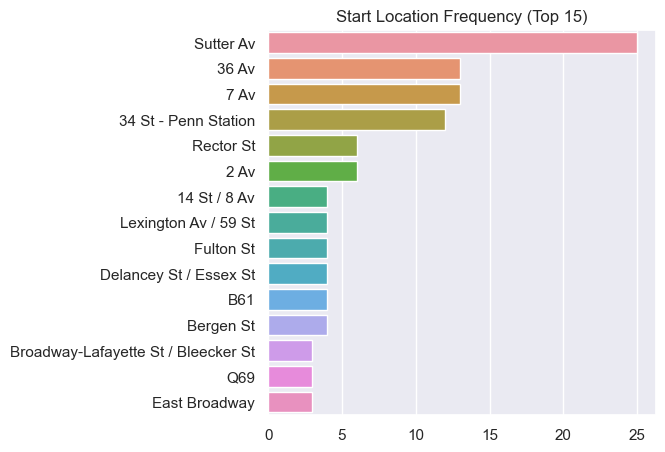

In [4]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(y=df['start_location'], order=df['start_location'].value_counts().iloc[:15].index).set(ylabel=None, xlabel=None, title='Start Location Frequency (Top 15)');

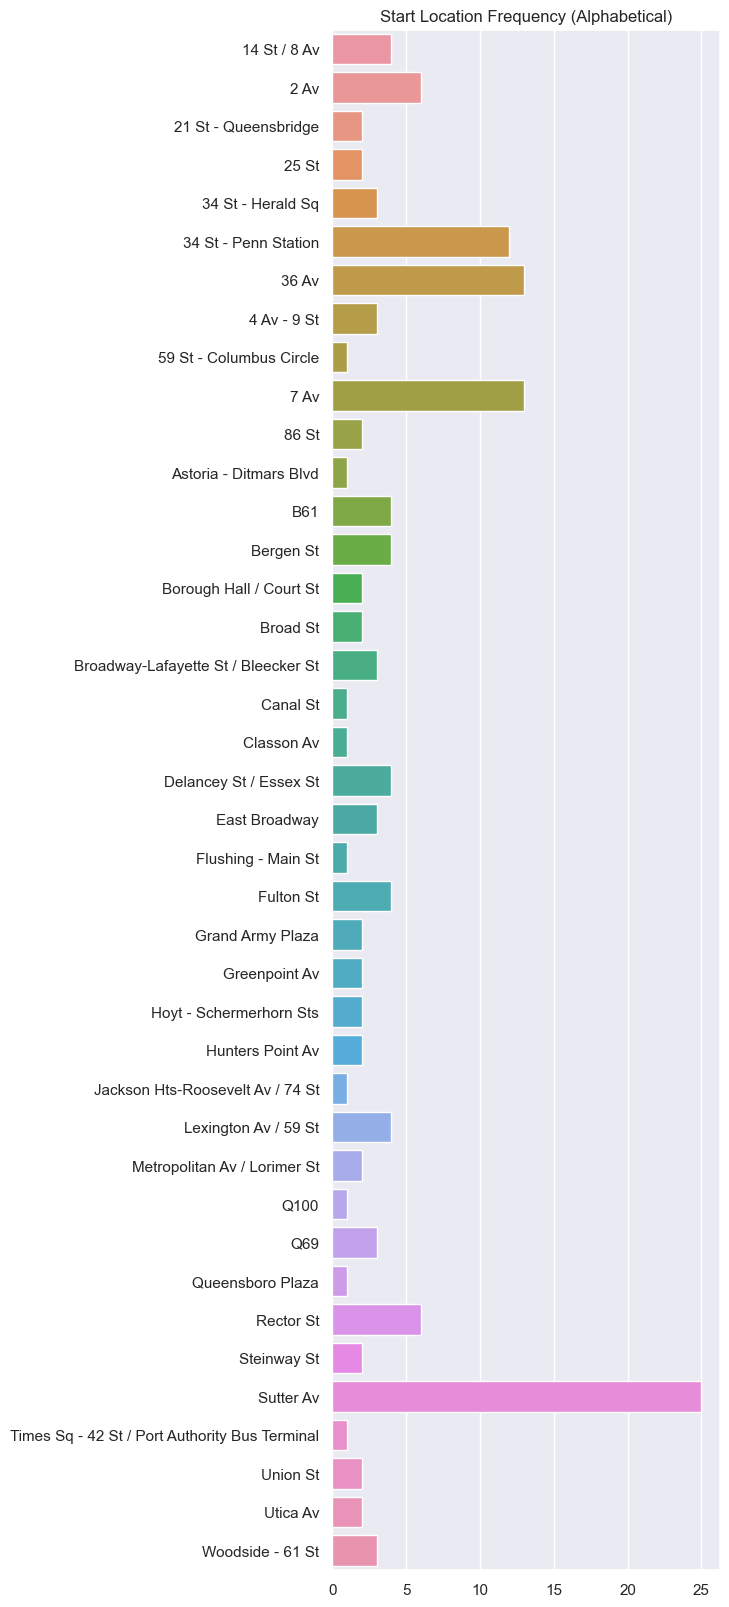

In [5]:
sns.set(rc={'figure.figsize':(5,20)})
sns.countplot(y=df['start_location']).set(ylabel=None, xlabel=None, title='Start Location Frequency (Alphabetical)');

In [6]:
# Output a Series with the Index as the location and the Value as the count
frequencies = df['start_location'].value_counts()

# Use the Series with a filter to get only the locations with a count of 1, and then get the count and the list of indices (location names)
print('Locations that have been visited only once:', len(frequencies[frequencies == 1]), sorted(frequencies[frequencies == 1].index.to_list()))

Locations that have been visited only once: 9 ['59 St - Columbus Circle', 'Astoria - Ditmars Blvd', 'Canal St', 'Classon Av', 'Flushing - Main St', 'Jackson Hts-Roosevelt Av / 74 St', 'Q100', 'Queensboro Plaza', 'Times Sq - 42 St / Port Authority Bus Terminal']


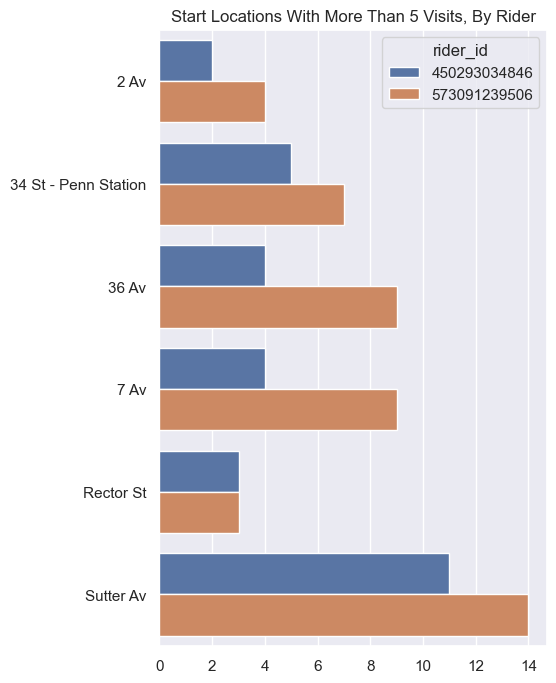

In [7]:
# Output a Series with the Index as the location and the Value as the count
frequencies = df['start_location'].value_counts()
# Output a Series of locations with 5 or more visits
high_frequencies = frequencies[frequencies >= 5]

# Output a new DataFrame with only the rows that match one of the most frequent start_location values
# add .copy() to avoid an error on the next operation saying `A value is trying to be set on a copy of a slice from a DataFrame.`
most_visited_locations = df[df['start_location'].isin(high_frequencies.index)].copy()
# Clear the unused start locations from its Category so Seaborn doesn't plot them
most_visited_locations['start_location'] = most_visited_locations['start_location'].cat.remove_unused_categories()


sns.set(rc={'figure.figsize':(5,8)})
sns.countplot(y=most_visited_locations['start_location'], hue=most_visited_locations['rider_id']).set(ylabel=None, xlabel=None, title='Start Locations With More Than 5 Visits, By Rider');

## Time-based analysis

- This looks at how transit happens over different time periods
  - What times of day are most common?
  - What days of the week are the most common?
  - What weeks, months, and quarters of the year had the most trips?
  - How many weeks went over the 12 ride fare cap, and how many came close?
  - What is the delta between riders per week, month, or quarter? AKA visualize how one rider's frequency compares to the others
- Resources
  - Floor a date based on a certain field `.dt.floor("H")` https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.floor.html?highlight=floor#pandas.Series.dt.floor
  - Count occurrences in a Series https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
  - Seaborn countplot which does the aggregation automatically https://seaborn.pydata.org/generated/seaborn.countplot.html
  - DataFrame group by month https://www.statology.org/pandas-group-by-month/
  - DataFrame group by multiple columns using square braces https://jamesrledoux.com/code/group-by-aggregate-pandas
  - Barplot reference with orient https://seaborn.pydata.org/generated/seaborn.barplot.html
  - Converting a numeric month to a named month using calendar https://stackoverflow.com/questions/37625334/convert-month-int-to-month-name-in-pandas
  - Breaking up a multi index by running a reset_index https://pandas.pydata.org/docs/reference/api/pandas.Series.reset_index.html
  - Pandas time to string convert https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.strftime.html using the Python formatting reference https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
  - Convert datetime to day of week https://stackoverflow.com/questions/60214194/error-in-reading-stock-data-datetimeproperties-object-has-no-attribute-week
  - Set a specific barplot order https://stackoverflow.com/questions/49034829/keep-weekdays-ordered-on-pandas-boxplot-using-seaborn
  - Group dates by quarter https://stackoverflow.com/questions/49362685/transform-a-datetime-column-to-yyyyqx-with-quarter-number
  - Format a datetime field into a YYY-WW number https://stackoverflow.com/questions/31181295/converting-a-pandas-date-to-week-number
  - Add a vline or hline to an axis in a figure https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvline.html (note that seaborn's line will need to set a variable representing the Axes, and then that variable will be called and modified)
  - Set specific x tick or y tick labels `ax.set(xticks=arange(1,22,2))` https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html https://stackoverflow.com/questions/58476654/how-to-remove-or-hide-x-axis-labels-from-a-seaborn-matplotlib-plot
  - Use `arange` to get a specific list of values https://www.w3resource.com/numpy/array-creation/arange.php
  - More xtick information, but not what I used https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html though it did note xticklabels should not be used

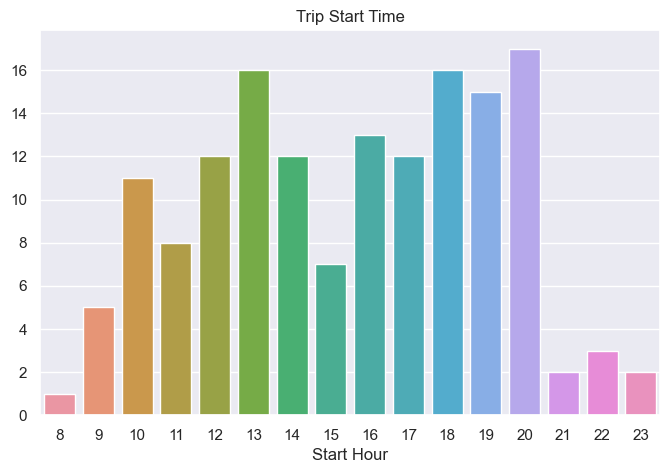

In [8]:
# Get the hour in which the start_time occurred
df['start_hour'] = df['start_time'].dt.hour

sns.set(rc={'figure.figsize':(8,5)})
sns.countplot(data=df, x=df['start_hour']).set(ylabel=None, xlabel='Start Hour', title='Trip Start Time');

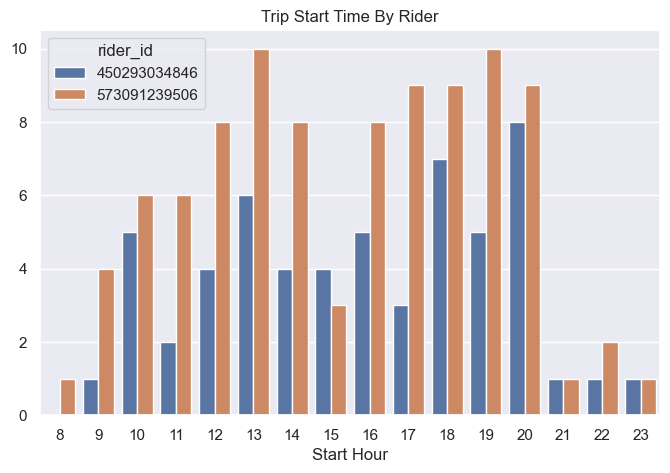

In [9]:
# Separate out the start hour by rider, to more easily see per-person trends
sns.countplot(data=df, x=df['start_hour'], hue=df['rider_id']).set(ylabel=None, xlabel='Start Hour', title='Trip Start Time By Rider');

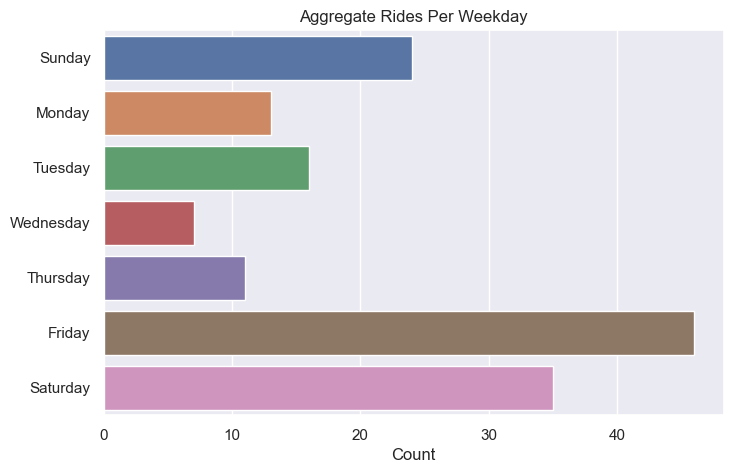

In [10]:
# What days of the week had the most trips?
weekday_frequency = df.groupby([df['start_time'].dt.day_name()])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
weekday_frequency = weekday_frequency.reset_index()

# Set the order of the fields
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=weekday_frequency, x='fare_cost', y='start_time', order=order).set(ylabel=None, xlabel='Count', title='Aggregate Rides Per Weekday');

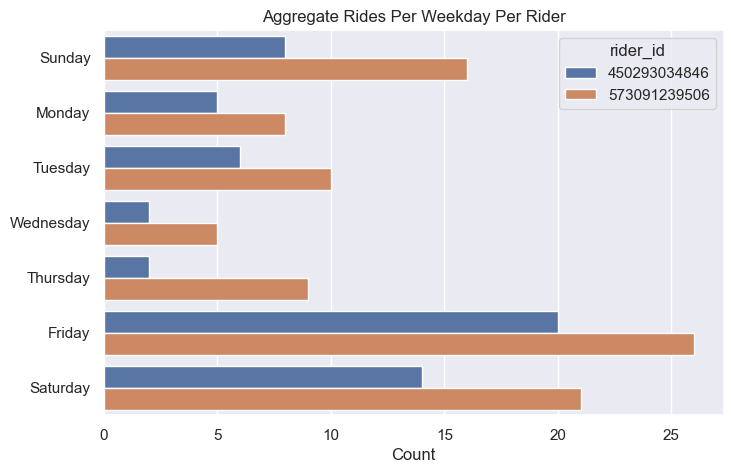

In [11]:
# What days of the week had the most trips per rider?
weekday_frequency = df.groupby([df['start_time'].dt.day_name(), df['rider_id']])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
weekday_frequency = weekday_frequency.reset_index()

# Set the order of the fields
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=weekday_frequency, x='fare_cost', y='start_time', order=order, hue='rider_id').set(ylabel=None, xlabel='Count', title='Aggregate Rides Per Weekday Per Rider');

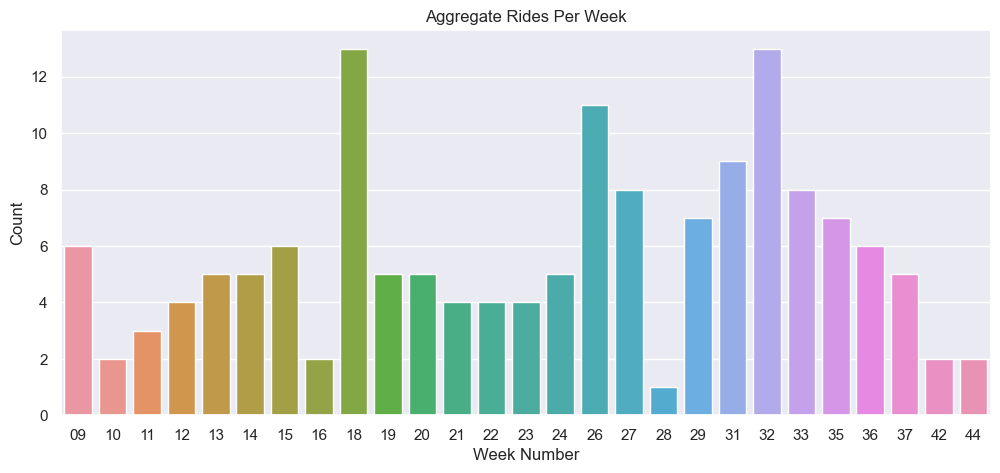

In [12]:
# What weeks of the year have the most trips?
week_frequency = df.groupby([df['start_time'].dt.strftime('%W')])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
week_frequency = week_frequency.reset_index()

sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(data=week_frequency, x='start_time', y='fare_cost').set(ylabel='Count', xlabel='Week Number', title='Aggregate Rides Per Week');

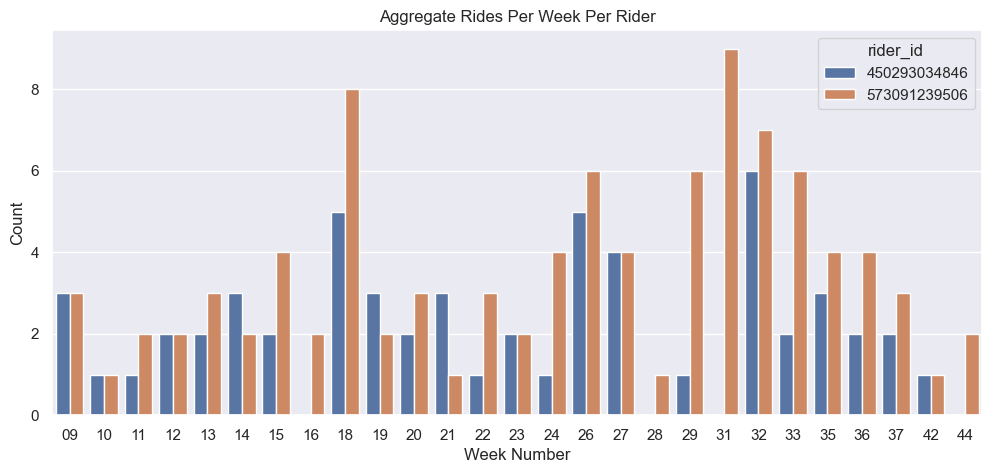

In [13]:
# What weeks of the year have the most trips per rider?
week_frequency = df.groupby([df['start_time'].dt.strftime('%W'), df['rider_id']])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
week_frequency = week_frequency.reset_index()

sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(data=week_frequency, x='start_time', y='fare_cost', hue='rider_id').set(ylabel='Count', xlabel='Week Number', title='Aggregate Rides Per Week Per Rider');

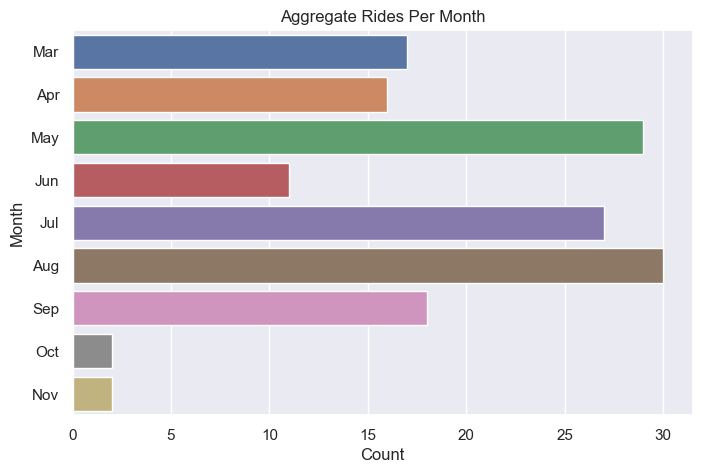

In [14]:
# What months of the year had the most trips?
month_frequency = df.groupby([df['start_time'].dt.month])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
month_frequency = month_frequency.reset_index()

# Relabel the numeric months to named months
month_frequency['month'] = month_frequency['start_time'].apply(lambda x: calendar.month_abbr[x])

sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=month_frequency, x='fare_cost', y='month', orient='h').set(ylabel='Month', xlabel='Count', title='Aggregate Rides Per Month');

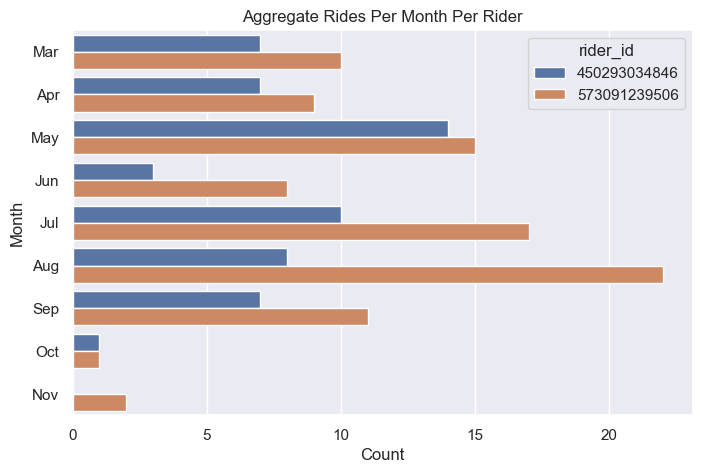

In [15]:
# What months of the year have the most trips per rider?
month_frequency = df.groupby([df['start_time'].dt.month, df['rider_id']])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
month_frequency = month_frequency.reset_index()

# Relabel the numeric months to named months
month_frequency['month'] = month_frequency['start_time'].apply(lambda x: calendar.month_abbr[x])

sns.barplot(data=month_frequency, x='fare_cost', y='month', orient='h', hue='rider_id').set(ylabel='Month', xlabel='Count', title='Aggregate Rides Per Month Per Rider');

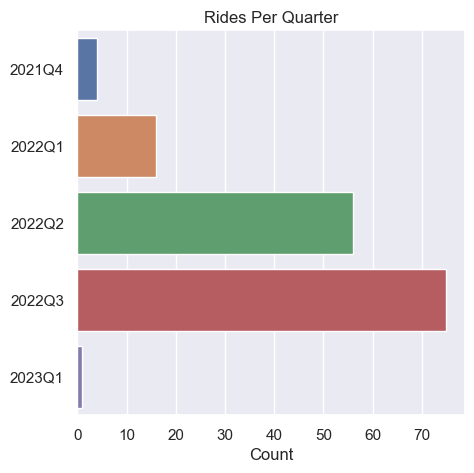

In [16]:
# What quarters of each year had the most trips?
quarter_frequency = df.groupby([df['start_time'].dt.to_period('Q')])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
quarter_frequency = quarter_frequency.reset_index()

sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=quarter_frequency, x='fare_cost', y='start_time').set(ylabel=None, xlabel='Count', title='Rides Per Quarter');

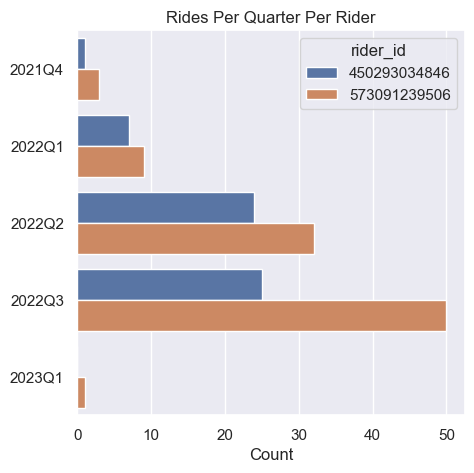

In [17]:
# What quarters of each year had the most trips per rider?
quarter_frequency = df.groupby([df['start_time'].dt.to_period('Q'), df['rider_id']])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
quarter_frequency = quarter_frequency.reset_index()

sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=quarter_frequency, x='fare_cost', y='start_time', hue='rider_id').set(ylabel=None, xlabel='Count', title='Rides Per Quarter Per Rider');

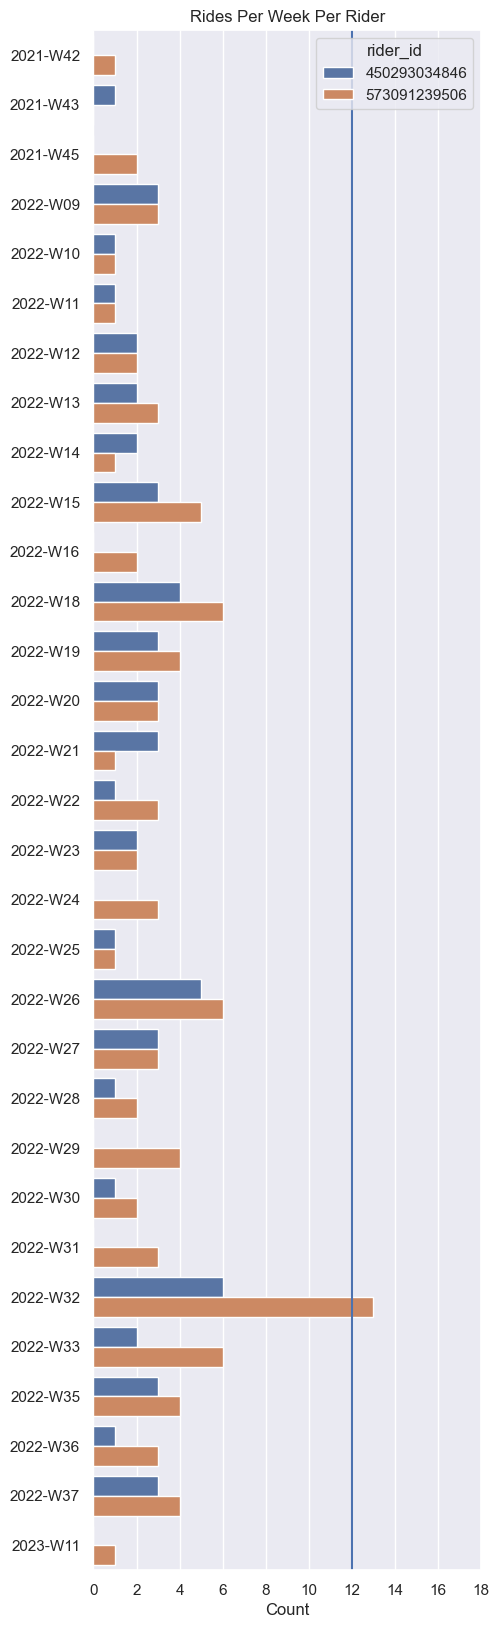

In [18]:
# How many weeks went over the 12 ride fare cap, and how many came close?
# TODO perhaps change this to the resample method, so weeks with 0 transit are still included. Right now week 2021-W44 had no travel and is missing
week_frequency = df.groupby([df['start_time'].dt.strftime('%Y-W%U'), df['rider_id']])['fare_cost'].count()

# Convert the Multi Index Series into a DataFrame 
week_frequency = week_frequency.reset_index()

sns.set(rc={'figure.figsize':(5,20)})
ax = sns.barplot(data=week_frequency, x='fare_cost', y='start_time', hue='rider_id')
ax.set(ylabel=None, xlabel='Count', title='Rides Per Week Per Rider', xticks=np.arange(0,20,2))
ax.axvline(12,0,1);

## Cost-based analysis 

- This looks at the financial side of things
  - What starting day of the week best utilizes the fare cap?
  - What is the average/max monthly spend rate?
- Resources
  - Resample allows grouping more intelligently by date columns https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
  - Resample offsets https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
  - More resample info https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
  - Anchored offsets to allow different week start days https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
  - I can couple a groupby with a resample https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.resample.html
  - When dropping columns, remember to include axis=1 https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
  - Grouping by using a series https://stackoverflow.com/questions/33483670/how-to-group-a-series-by-values-in-pandas https://pandas.pydata.org/docs/reference/api/pandas.Series.groupby.html
  - Concatenation of multiple series into a single DataFrame based on their index value (not merging, not joining) https://stackoverflow.com/questions/18083187/combining-two-series-in-pandas-along-their-index https://pandas.pydata.org/docs/reference/api/pandas.concat.html
  - Define a function https://www.w3schools.com/python/python_functions.asp
  - Sort a dataframe by its index in increasing order https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_index.html
  - Seaborn Line Plot https://seaborn.pydata.org/generated/seaborn.lineplot.html
  - Collapse a DataFrame into a Series where the rows are the old column titles and the values are the sum of the columns https://sparkbyexamples.com/python/pandas-sum-dataframe-columns
  - Catplot https://seaborn.pydata.org/generated/seaborn.catplot.html
  - DataFrame renaming using position rather than name https://stackoverflow.com/questions/43759921/pandas-rename-column-by-position
  - DataFrame subset selection using double square brackets https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

In [19]:
# What starting day of the week best utilizes the fare cap?

# Optional: Uncomment to filter based on rider_id
#print(df['rider_id'].unique())
#df=df[df['rider_id'] == '1234567890']

def calculate_weekly_rides(day_of_week):
    # Define the anchored offset, aka W-SUN, W-WED, W-FRI, etc. 
    anchored_offset = 'W-'+day_of_week
    # Create a new DataFrame counting the number of rides per week per rider, where the week is defined by the anchored offset
    resampled = df.groupby(['rider_id']).resample(anchored_offset, on='start_time').count()
    # Remove the groupby column duplicate (that also now exists in the multi-index) that would prevent a reset_index
    resampled = resampled.drop(['rider_id'], axis=1)
    # Then reset the index and grab an arbitrary column from the resulting DataFrame, as all the columns have identical data
    resampled_series = resampled.reset_index()['trip_id']
    # Next, group on the number of rides to know how many occurrences exist for each ride count per week
    # Finally rename it to the week start day it's representing
    resampled_series = resampled_series.groupby(resampled_series).count().rename(day_of_week)
    return resampled_series

# Use the helper to calculate all possibile week start days and concatenate them into a DataFrame
# Sort the index to force ascending order
merged = pd.concat([calculate_weekly_rides('SUN'), 
                    calculate_weekly_rides('MON'),
                   calculate_weekly_rides('TUE'),
                   calculate_weekly_rides('WED'),
                   calculate_weekly_rides('THU'),
                   calculate_weekly_rides('FRI'),
                   calculate_weekly_rides('SAT')], axis=1).sort_index()

# Rename the index to be clearer
merged.index = merged.index.rename('Rides Taken')

merged

,SUN,MON,TUE,WED,THU,FRI,SAT
Rides Taken,,,,,,,
0,71.0,72.0,72.0,73.0,74.0,70.0,67.0
1,12.0,12.0,10.0,10.0,11.0,10.0,15.0
2,14.0,13.0,16.0,14.0,13.0,17.0,11.0
3,10.0,8.0,5.0,6.0,7.0,9.0,16.0
4,6.0,10.0,9.0,9.0,6.0,8.0,5.0
5,2.0,1.0,2.0,3.0,3.0,3.0,2.0
6,4.0,2.0,4.0,3.0,2.0,3.0,4.0
7,1.0,1.0,2.0,1.0,3.0,NaN,NaN
8,1.0,1.0,NaN,NaN,NaN,NaN,NaN


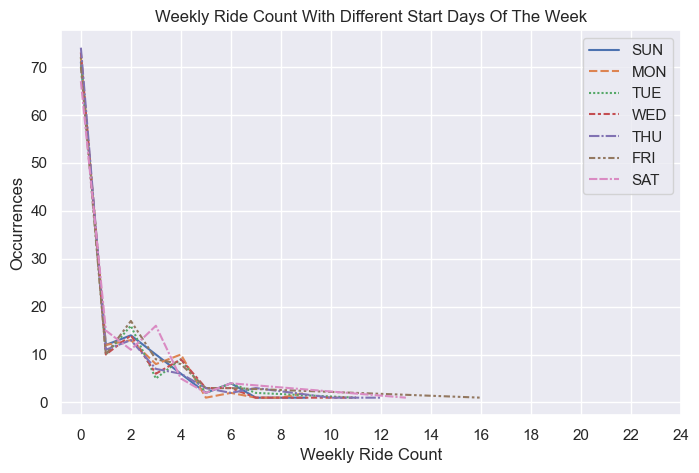

In [20]:
sns.set(rc={'figure.figsize':(8,5)})
sns.lineplot(data=merged).set(ylabel='Occurrences', xlabel='Weekly Ride Count', title='Weekly Ride Count With Different Start Days Of The Week', xticks=np.arange(0,26,2));

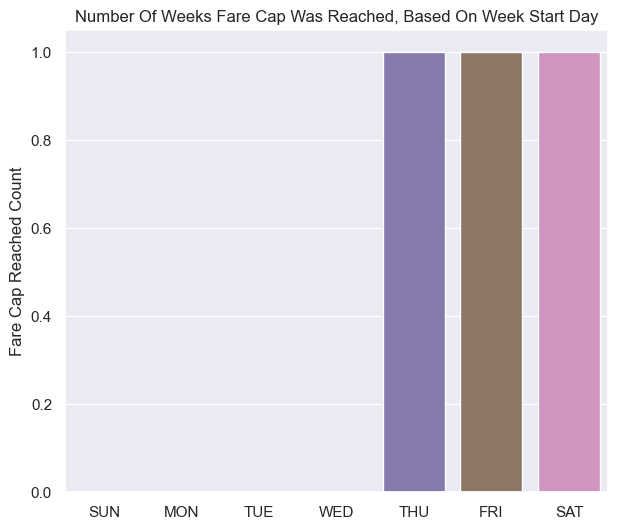

In [21]:
# How many weeks does the fare cap get reached, based on different start days?

# Filter the merged dataframe to rows with index 12 or more, and then group by and sum the number of weeks
# Reset the index to convert it to a DataFrame
fare_cap_rides = merged[merged.index >= 12].sum().reset_index()
# Rename the columns to be more readable
fare_cap_rides = fare_cap_rides.rename(columns={fare_cap_rides.columns[0]:'weekday',fare_cap_rides.columns[1]:'count'})

sns.set(rc={'figure.figsize':(7,6)})
sns.barplot(data=fare_cap_rides, x='weekday', y='count').set(ylabel='Fare Cap Reached Count', xlabel=None, title='Number Of Weeks Fare Cap Was Reached, Based On Week Start Day');

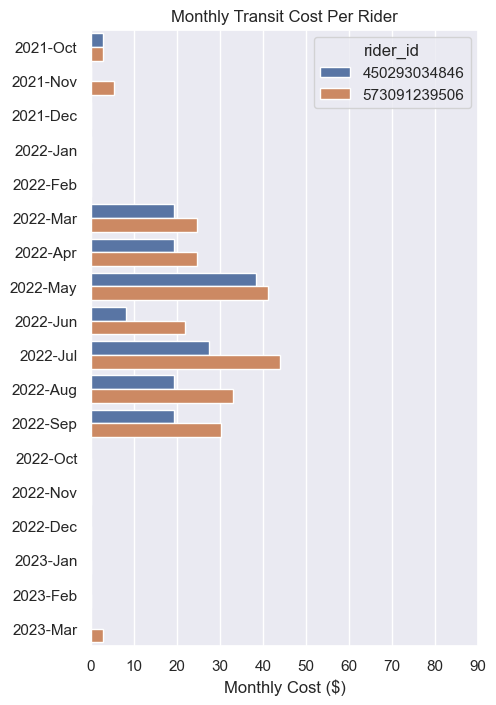

In [22]:
# What is the monthly spend rate?

# Select only the columns needed for grouping and summing, group and resample, and then sum on the fare cost.
# Reset the index to split out the multi index
resampled = df[['rider_id','start_time','fare_cost']].groupby(['rider_id']).resample('M', on='start_time').sum().reset_index()
# Change the date column to be more readable, YYYY-month instead of YYYY-MM-DD HH:MM:SS
resampled['start_time'] = resampled['start_time'].dt.strftime('%Y-%b')

sns.set(rc={'figure.figsize':(5,8)})
sns.barplot(x='fare_cost', y='start_time', hue='rider_id', data=resampled).set(ylabel=None, xlabel='Monthly Cost ($)', title='Monthly Transit Cost Per Rider', xticks=np.arange(0,100,10));

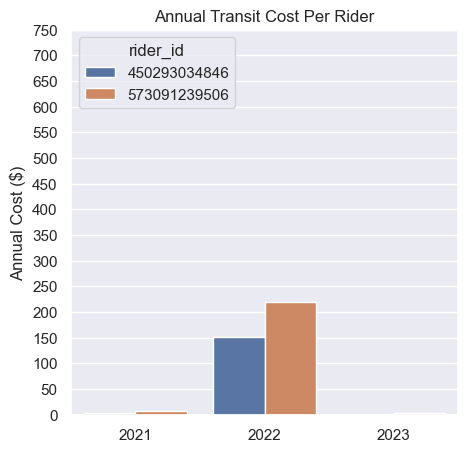

In [23]:
# What is the annual spend rate?

# Select only the columns needed for grouping and summing, group and resample, and then sum on the fare cost.
# Reset the index to split out the multi index
resampled = df[['rider_id','start_time','fare_cost']].groupby(['rider_id']).resample('Y', on='start_time').sum().reset_index()
# Change the date column to be more readable, YYYY instead of YYYY-MM-DD HH:MM:SS
resampled['start_time'] = resampled['start_time'].dt.strftime('%Y')

sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(y='fare_cost', x='start_time', hue='rider_id', data=resampled).set(xlabel=None, ylabel='Annual Cost ($)', title='Annual Transit Cost Per Rider', yticks=np.arange(0,800,50));

In [24]:
# How much savings were there from the fare cap?

free_rides = df[df['fare_cost'] == 0]
free_rides = free_rides[free_rides['product_type'].str.contains('Fare Cap')]
print('So far, there have been',len(free_rides),'rides that were free due to the fare cap being reached')
free_rides

So far, there have been 9 rides that were free due to the fare cap being reached


,trip_id,rider_id,start_time,transit_mode,start_location,product_type,fare_cost,start_hour
131,71788068,573091239506,2022-08-07 17:53:36,Subway,Times Sq - 42 St / Port Authority Bus Terminal,Free Trip – Weekly Fare Cap,0.0,17
132,71778009,573091239506,2022-08-07 16:22:53,Subway,Queensboro Plaza,Free Trip – Weekly Fare Cap,0.0,16
134,71766637,573091239506,2022-08-07 14:46:54,Subway,7 Av,Free Trip – Weekly Fare Cap,0.0,14
135,71745491,573091239506,2022-08-07 10:44:23,Subway,36 Av,Free Trip – Weekly Fare Cap,0.0,10
136,71741914,573091239506,2022-08-07 08:58:52,Subway,7 Av,Free Trip – Weekly Fare Cap,0.0,8
137,71661761,573091239506,2022-08-06 12:41:03,Subway,2 Av,Free Trip – Weekly Fare Cap,0.0,12
138,71655332,573091239506,2022-08-06 12:04:48,Subway,7 Av,Free Trip – Weekly Fare Cap,0.0,12
139,71639660,573091239506,2022-08-06 09:01:19,Subway,36 Av,Free Trip – Weekly Fare Cap,0.0,9
141,69993189,573091239506,2022-07-24 16:04:29,Subway,14 St / 8 Av,Free Trip – Weekly Fare Cap,0.0,16


In [26]:
# How many free transfers were there?

free_rides = df[df['fare_cost'] == 0]
free_rides = free_rides[free_rides['product_type'].str.contains('Transfer')]
print('So far, there have been',len(free_rides),'rides that were free transfers')

So far, there have been 3 rides that were free transfers
